## **Importing libraries and datasets**

In [20]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
from xgboost import plot_importance


In [3]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [6]:
#customer level
print(df_response.shape)
df_response.head()

(6884, 2)


,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [7]:
#trans level
print(df_transactions.shape)
df_transactions.head() 

(125000, 3)


,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [8]:
print(df_transactions['trans_date'].min()) #ข้อมูลวันแรก
print(df_transactions['trans_date'].max()) #ข้อมูลวันสุดท้าย

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [15]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17) #วันที่เริ่มทำ campaign

df_transactions['recent']= campaign_date - df_transactions['trans_date'] 
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D') #วันที่ลูกค้าเข้ามาห่างจากวัน campaign กี่วัน

df_transactions['age'] = (campaign_date - df_transactions['trans_date']).dt.days
df_transactions['is_weekend'] = df_transactions['trans_date'].dt.weekday.isin([5,6])

basket_cuts = [0,35,80,float('inf')]
df_transactions['basket_size'] = pd.cut(df_transactions['tran_amount'], basket_cuts, right=False, labels=['S','M','L'])

df_transactions = df_transactions.sort_values(['customer_id','trans_date'])
df_transactions.head()

,customer_id,trans_date,tran_amount,recent,age,is_weekend,basket_size
77247,CS1112,2011-06-15,56,1371.0,1371,False,M
89149,CS1112,2011-08-19,96,1306.0,1306,False,L
68206,CS1112,2011-10-02,60,1262.0,1262,True,M
36486,CS1112,2012-04-08,56,1073.0,1073,True,M
93074,CS1112,2012-06-24,52,996.0,996,True,M


In [16]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()})               # Monetary Value           


df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)

In [17]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,15,1012
1,CS1113,36.0,20,1490
2,CS1114,33.0,19,1432
3,CS1115,12.0,22,1659
4,CS1116,204.0,13,857


## เพิ่มตัวแปร Model อาจดีขึ้น

In [21]:
## create data set with CLV variables
df = df_transactions.groupby('customer_id').agg(
        recency=('age', min),                       
        frequency=('customer_id', len),                  
        monetary=('tran_amount', sum), 
        tenure=('age', max),
        length_of_stay=('age', lambda x: x.max() - x.min()),
     )

# weekend stats
weekend_df = df_transactions.groupby(['customer_id','is_weekend'])['tran_amount'].agg(['size','sum','mean']).unstack(fill_value=0)
weekend_df.columns = ['visit_weekday','visit_weekend','spend_weekday','spend_weekend','ticket_size_weekday','ticket_size_weekend']
df = df.join(weekend_df)

# basket size stats
basket_size_df = df_transactions.groupby(['customer_id','basket_size'])['tran_amount'].agg(['size','sum']).unstack()
basket_size_df.columns = ['visit_basket_s','visit_basket_m','visit_basket_l','spend_basket_s','spend_basket_m','spend_basket_l']
df = df.join(basket_size_df)

df = df.join(df_transactions.groupby('customer_id').agg(
    ticket_size=('tran_amount','mean'),
    std_ticket_size=('tran_amount','std'),
    med_ticket_size=('tran_amount','median'),
    mad_ticket_size=('tran_amount','mad'),
    
))

# Time to Event
event_df = df_transactions.groupby(['customer_id','trans_date']).size().reset_index(name='num_trans')
event_df['prev_date'] = event_df.groupby('customer_id')['trans_date'].shift(1)
event_df['num_repeat_sameday'] = event_df['num_trans'] - 1
event_df['duration'] = (event_df['trans_date'] - event_df['prev_date']).dt.days

df = df.join(event_df.groupby('customer_id').agg(avg_duration=('duration','mean'),std_duration=('duration','std'),
                                                # med_duration=('duration','median'), mad_duration=('duration','mad'),
                                                num_repeat_periods=('trans_date', lambda x: x.count() - 1),
                                                num_repeat_sameday=('num_repeat_sameday','sum')))

# df['recency_score'] = (df['recency'] - df['avg_duration'])/df['std_duration']
# df['recency_score'] = np.log(df['recency'] / df['avg_duration'])

# RFM & Time to event for each past X months
periods = [6, 12, 18, 24]
for n in periods:
    window_df = df_transactions[df_transactions.trans_date > df_transactions.trans_date.max() - relativedelta(months=n)]

    df = df.join(window_df.groupby('customer_id')['tran_amount'].agg(
        [ (f'monetary_{n}m','sum'), (f'frequency_{n}m', 'size'), 
        (f'avg_spend_{n}m', 'mean'), (f'std_spend_{n}m', 'std'),
         (f'iqr_spend_{n}m', lambda x: x.quantile(0.75) - x.quantile(0.25))]
    ))

    event_df = window_df.groupby(['customer_id','trans_date']).size().reset_index(name='num_trans')
    event_df['prev_date'] = event_df.groupby('customer_id')['trans_date'].shift(1)
    event_df['duration'] = (event_df['trans_date'] - event_df['prev_date']).dt.days
    df = df.join(event_df.groupby('customer_id')['duration'].agg(
        [ (f'avg_dur_{n}m', 'mean'), (f'std_dur_{n}m', 'std'), 
         (f'iqr_dur_{n}m', lambda x: x.quantile(.75) - x.quantile(.25)),
         (f'num_repeat_{n}m', 'count')
         ]
    ))

df['velocity_monetary_6_12'] = df['avg_spend_6m'] / (df['monetary_12m']/12)
df['velocity_monetary_6_18'] = df['avg_spend_6m'] / (df['monetary_18m']/18)
df['velocity_monetary_6_24'] = df['avg_spend_6m'] / (df['monetary_24m']/24)
df['velocity_monetary_12_18'] = df['avg_spend_12m'] / (df['monetary_18m']/18)
df['velocity_monetary_12_24'] = df['avg_spend_12m'] / (df['monetary_24m']/24)


df.fillna(0, inplace=True)
df = df_response.set_index('customer_id').join(df)
df.head()


,response,recency,frequency,monetary,tenure,length_of_stay,visit_weekday,visit_weekend,spend_weekday,spend_weekend,ticket_size_weekday,ticket_size_weekend,visit_basket_s,visit_basket_m,visit_basket_l,spend_basket_s,spend_basket_m,spend_basket_l,ticket_size,std_ticket_size,med_ticket_size,mad_ticket_size,avg_duration,std_duration,num_repeat_periods,num_repeat_sameday,monetary_6m,frequency_6m,avg_spend_6m,std_spend_6m,iqr_spend_6m,avg_dur_6m,std_dur_6m,iqr_dur_6m,num_repeat_6m,monetary_12m,frequency_12m,avg_spend_12m,std_spend_12m,iqr_spend_12m,avg_dur_12m,std_dur_12m,iqr_dur_12m,num_repeat_12m,monetary_18m,frequency_18m,avg_spend_18m,std_spend_18m,iqr_spend_18m,avg_dur_18m,std_dur_18m,iqr_dur_18m,num_repeat_18m,monetary_24m,frequency_24m,avg_spend_24m,std_spend_24m,iqr_spend_24m,avg_dur_24m,std_dur_24m,iqr_dur_24m,num_repeat_24m,velocity_monetary_6_12,velocity_monetary_6_18,velocity_monetary_6_24,velocity_monetary_12_18,velocity_monetary_12_24
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CS1112,0,62,15,1012,1371,1309,10,5,696,316,69.600000,63.200000,0,11,4,0.0,640.0,372.0,67.466667,19.766012,63.0,15.831111,93.500000,50.873523,14,0,98.0,2.0,49.000000,14.142136,10.0,41.0,0.000000,0.0,1.0,251.0,4.0,62.750000,20.982135,15.75,86.666667,50.560195,50.00,3.0,322.0,5.0,64.400000,18.541845,12.00,106.750000,57.598466,78.75,4.0,358.0,6.0,59.666667,20.235283,25.0,112.400000,51.456778,63.00,5.0,2.342629,2.739130,3.284916,3.507764,4.206704
CS1113,0,36,20,1490,1390,1354,17,3,1296,194,76.235294,64.666667,0,10,10,0.0,566.0,924.0,74.500000,21.254102,79.5,18.300000,75.222222,53.395919,18,1,220.0,3.0,73.333333,27.300794,27.0,26.0,0.000000,0.0,1.0,393.0,6.0,65.500000,28.939592,51.25,74.000000,65.181797,54.50,4.0,446.0,7.0,63.714286,26.837252,45.50,79.600000,57.821276,64.00,5.0,775.0,11.0,70.454545,23.888757,43.0,73.333333,58.030165,76.00,9.0,2.239186,2.959641,2.270968,2.643498,2.028387
CS1114,1,33,19,1432,1342,1309,13,6,955,477,73.461538,79.500000,0,10,9,0.0,589.0,843.0,75.368421,21.341692,79.0,17.955679,72.722222,73.693168,18,0,211.0,3.0,70.333333,29.955523,29.0,31.0,16.970563,12.0,2.0,315.0,5.0,63.000000,23.822258,33.00,41.250000,44.002841,43.25,4.0,652.0,9.0,72.444444,26.495807,49.00,53.375000,69.903888,42.50,8.0,804.0,11.0,73.090909,24.010225,42.5,62.600000,64.740851,82.00,10.0,2.679365,1.941718,2.099502,1.739264,1.880597
CS1115,1,12,22,1659,1315,1303,16,6,1183,476,73.937500,79.333333,0,13,9,0.0,816.0,843.0,75.409091,18.151896,72.5,15.264463,62.047619,55.413425,21,0,55.0,1.0,55.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,248.0,3.0,82.666667,24.006943,21.50,165.000000,134.350288,95.00,2.0,590.0,8.0,73.750000,16.951612,16.75,76.142857,85.762130,54.00,7.0,831.0,11.0,75.545455,15.577956,19.5,71.500000,71.019950,47.75,10.0,2.661290,1.677966,1.588448,2.522034,2.387485
CS1116,1,204,13,857,1359,1155,12,1,797,60,66.416667,60.000000,0,8,5,0.0,399.0,458.0,65.923077,22.940000,60.0,19.751479,96.250000,107.361010,12,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,286.0,4.0,71.500000,26.248809,36.50,52.333333,37.740341,34.50,3.0,333.0,5.0,66.600000,25.234896,43.00,49.750000,31.245000,38.25,4.0,333.0,5.0,66.600000,25.234896,43.0,49.750000,31.245000,38.25,4.0,0.000000,0.000000,0.000000,3.864865,5.153153


In [22]:
df = df.reset_index()
df.head()

,customer_id,response,recency,frequency,monetary,tenure,length_of_stay,visit_weekday,visit_weekend,spend_weekday,spend_weekend,ticket_size_weekday,ticket_size_weekend,visit_basket_s,visit_basket_m,visit_basket_l,spend_basket_s,spend_basket_m,spend_basket_l,ticket_size,std_ticket_size,med_ticket_size,mad_ticket_size,avg_duration,std_duration,num_repeat_periods,num_repeat_sameday,monetary_6m,frequency_6m,avg_spend_6m,std_spend_6m,iqr_spend_6m,avg_dur_6m,std_dur_6m,iqr_dur_6m,num_repeat_6m,monetary_12m,frequency_12m,avg_spend_12m,std_spend_12m,iqr_spend_12m,avg_dur_12m,std_dur_12m,iqr_dur_12m,num_repeat_12m,monetary_18m,frequency_18m,avg_spend_18m,std_spend_18m,iqr_spend_18m,avg_dur_18m,std_dur_18m,iqr_dur_18m,num_repeat_18m,monetary_24m,frequency_24m,avg_spend_24m,std_spend_24m,iqr_spend_24m,avg_dur_24m,std_dur_24m,iqr_dur_24m,num_repeat_24m,velocity_monetary_6_12,velocity_monetary_6_18,velocity_monetary_6_24,velocity_monetary_12_18,velocity_monetary_12_24
0,CS1112,0,62,15,1012,1371,1309,10,5,696,316,69.600000,63.200000,0,11,4,0.0,640.0,372.0,67.466667,19.766012,63.0,15.831111,93.500000,50.873523,14,0,98.0,2.0,49.000000,14.142136,10.0,41.0,0.000000,0.0,1.0,251.0,4.0,62.750000,20.982135,15.75,86.666667,50.560195,50.00,3.0,322.0,5.0,64.400000,18.541845,12.00,106.750000,57.598466,78.75,4.0,358.0,6.0,59.666667,20.235283,25.0,112.400000,51.456778,63.00,5.0,2.342629,2.739130,3.284916,3.507764,4.206704
1,CS1113,0,36,20,1490,1390,1354,17,3,1296,194,76.235294,64.666667,0,10,10,0.0,566.0,924.0,74.500000,21.254102,79.5,18.300000,75.222222,53.395919,18,1,220.0,3.0,73.333333,27.300794,27.0,26.0,0.000000,0.0,1.0,393.0,6.0,65.500000,28.939592,51.25,74.000000,65.181797,54.50,4.0,446.0,7.0,63.714286,26.837252,45.50,79.600000,57.821276,64.00,5.0,775.0,11.0,70.454545,23.888757,43.0,73.333333,58.030165,76.00,9.0,2.239186,2.959641,2.270968,2.643498,2.028387
2,CS1114,1,33,19,1432,1342,1309,13,6,955,477,73.461538,79.500000,0,10,9,0.0,589.0,843.0,75.368421,21.341692,79.0,17.955679,72.722222,73.693168,18,0,211.0,3.0,70.333333,29.955523,29.0,31.0,16.970563,12.0,2.0,315.0,5.0,63.000000,23.822258,33.00,41.250000,44.002841,43.25,4.0,652.0,9.0,72.444444,26.495807,49.00,53.375000,69.903888,42.50,8.0,804.0,11.0,73.090909,24.010225,42.5,62.600000,64.740851,82.00,10.0,2.679365,1.941718,2.099502,1.739264,1.880597
3,CS1115,1,12,22,1659,1315,1303,16,6,1183,476,73.937500,79.333333,0,13,9,0.0,816.0,843.0,75.409091,18.151896,72.5,15.264463,62.047619,55.413425,21,0,55.0,1.0,55.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,248.0,3.0,82.666667,24.006943,21.50,165.000000,134.350288,95.00,2.0,590.0,8.0,73.750000,16.951612,16.75,76.142857,85.762130,54.00,7.0,831.0,11.0,75.545455,15.577956,19.5,71.500000,71.019950,47.75,10.0,2.661290,1.677966,1.588448,2.522034,2.387485
4,CS1116,1,204,13,857,1359,1155,12,1,797,60,66.416667,60.000000,0,8,5,0.0,399.0,458.0,65.923077,22.940000,60.0,19.751479,96.250000,107.361010,12,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,286.0,4.0,71.500000,26.248809,36.50,52.333333,37.740341,34.50,3.0,333.0,5.0,66.600000,25.234896,43.00,49.750000,31.245000,38.25,4.0,333.0,5.0,66.600000,25.234896,43.0,49.750000,31.245000,38.25,4.0,0.000000,0.000000,0.000000,3.864865,5.153153


## **Calculating response rate**

In [23]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


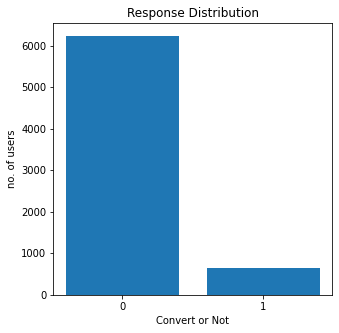

In [24]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [25]:
## merging two data sets - RFM

df_modeling_rfm = pd.merge(df_response,df_rfm)
df_modeling_rfm.head()

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,15,1012
1,CS1113,0,36.0,20,1490
2,CS1114,1,33.0,19,1432
3,CS1115,1,12.0,22,1659
4,CS1116,1,204.0,13,857


In [26]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary,tenure,length_of_stay,visit_weekday,visit_weekend,spend_weekday,spend_weekend,ticket_size_weekday,ticket_size_weekend,visit_basket_s,visit_basket_m,visit_basket_l,spend_basket_s,spend_basket_m,spend_basket_l,ticket_size,std_ticket_size,med_ticket_size,mad_ticket_size,avg_duration,std_duration,num_repeat_periods,num_repeat_sameday,monetary_6m,frequency_6m,avg_spend_6m,std_spend_6m,iqr_spend_6m,avg_dur_6m,std_dur_6m,iqr_dur_6m,num_repeat_6m,monetary_12m,frequency_12m,avg_spend_12m,std_spend_12m,iqr_spend_12m,avg_dur_12m,std_dur_12m,iqr_dur_12m,num_repeat_12m,monetary_18m,frequency_18m,avg_spend_18m,std_spend_18m,iqr_spend_18m,avg_dur_18m,std_dur_18m,iqr_dur_18m,num_repeat_18m,monetary_24m,frequency_24m,avg_spend_24m,std_spend_24m,iqr_spend_24m,avg_dur_24m,std_dur_24m,iqr_dur_24m,num_repeat_24m,velocity_monetary_6_12,velocity_monetary_6_18,velocity_monetary_6_24,velocity_monetary_12_18,velocity_monetary_12_24
0,CS1112,0,62,15,1012,1371,1309,10,5,696,316,69.600000,63.200000,0,11,4,0.0,640.0,372.0,67.466667,19.766012,63.0,15.831111,93.500000,50.873523,14,0,98.0,2.0,49.000000,14.142136,10.0,41.0,0.000000,0.0,1.0,251.0,4.0,62.750000,20.982135,15.75,86.666667,50.560195,50.00,3.0,322.0,5.0,64.400000,18.541845,12.00,106.750000,57.598466,78.75,4.0,358.0,6.0,59.666667,20.235283,25.0,112.400000,51.456778,63.00,5.0,2.342629,2.739130,3.284916,3.507764,4.206704
1,CS1113,0,36,20,1490,1390,1354,17,3,1296,194,76.235294,64.666667,0,10,10,0.0,566.0,924.0,74.500000,21.254102,79.5,18.300000,75.222222,53.395919,18,1,220.0,3.0,73.333333,27.300794,27.0,26.0,0.000000,0.0,1.0,393.0,6.0,65.500000,28.939592,51.25,74.000000,65.181797,54.50,4.0,446.0,7.0,63.714286,26.837252,45.50,79.600000,57.821276,64.00,5.0,775.0,11.0,70.454545,23.888757,43.0,73.333333,58.030165,76.00,9.0,2.239186,2.959641,2.270968,2.643498,2.028387
2,CS1114,1,33,19,1432,1342,1309,13,6,955,477,73.461538,79.500000,0,10,9,0.0,589.0,843.0,75.368421,21.341692,79.0,17.955679,72.722222,73.693168,18,0,211.0,3.0,70.333333,29.955523,29.0,31.0,16.970563,12.0,2.0,315.0,5.0,63.000000,23.822258,33.00,41.250000,44.002841,43.25,4.0,652.0,9.0,72.444444,26.495807,49.00,53.375000,69.903888,42.50,8.0,804.0,11.0,73.090909,24.010225,42.5,62.600000,64.740851,82.00,10.0,2.679365,1.941718,2.099502,1.739264,1.880597
3,CS1115,1,12,22,1659,1315,1303,16,6,1183,476,73.937500,79.333333,0,13,9,0.0,816.0,843.0,75.409091,18.151896,72.5,15.264463,62.047619,55.413425,21,0,55.0,1.0,55.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,248.0,3.0,82.666667,24.006943,21.50,165.000000,134.350288,95.00,2.0,590.0,8.0,73.750000,16.951612,16.75,76.142857,85.762130,54.00,7.0,831.0,11.0,75.545455,15.577956,19.5,71.500000,71.019950,47.75,10.0,2.661290,1.677966,1.588448,2.522034,2.387485
4,CS1116,1,204,13,857,1359,1155,12,1,797,60,66.416667,60.000000,0,8,5,0.0,399.0,458.0,65.923077,22.940000,60.0,19.751479,96.250000,107.361010,12,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,286.0,4.0,71.500000,26.248809,36.50,52.333333,37.740341,34.50,3.0,333.0,5.0,66.600000,25.234896,43.00,49.750000,31.245000,38.25,4.0,333.0,5.0,66.600000,25.234896,43.0,49.750000,31.245000,38.25,4.0,0.000000,0.000000,0.000000,3.864865,5.153153


## **Creating train and test dataset**

In [27]:
## spliting dataframe into X and y

X_rfm = df_modeling_rfm.drop(columns=['response','customer_id'])
y_rfm = df_modeling_rfm['response']

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

In [28]:
## creating train and test dataset

X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.3, random_state=0)
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=0)

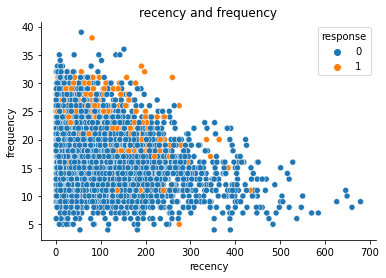

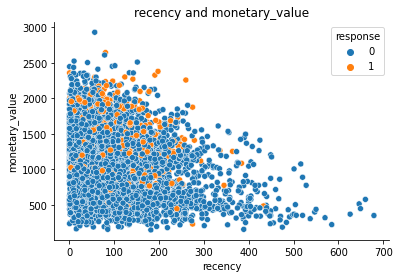

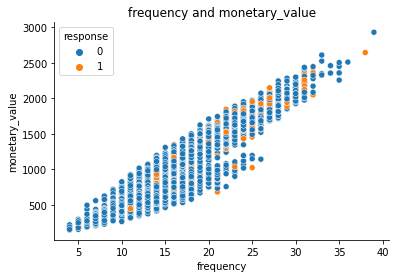

In [29]:
for i, col_i in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
  for j, col_j in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_rfm, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

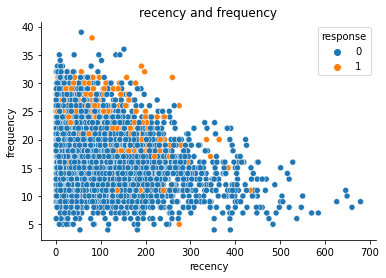

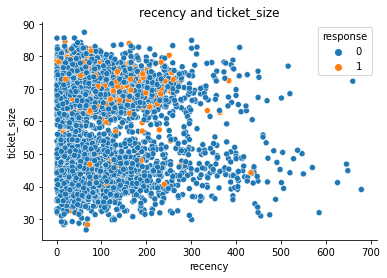

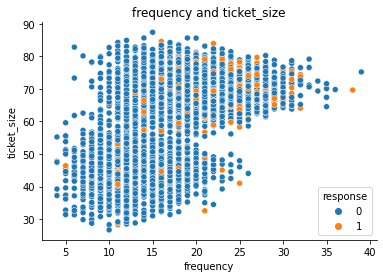

In [32]:
for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'ticket_size']].columns):
  for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'ticket_size']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

## **Fixing imbalanced with SMOTE**

In [37]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=0)

sm.fit(X_train_clv, y_train_rfm)
X_SMOTE_rfm, y_SMOTE_rfm = sm.fit_resample(X_train_rfm, y_train_rfm)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_resample(X_train_clv, y_train_clv)

## **Logistic Regression**

In [38]:
print('logistic regression model - SMOTE RFM')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_rfm = logreg.fit(X_SMOTE_rfm, y_SMOTE_rfm)
predictions = logreg_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE RFM
training set
              precision    recall  f1-score   support

           0       0.69      0.59      0.64      4389
           1       0.64      0.73      0.69      4389

    accuracy                           0.66      8778
   macro avg       0.67      0.66      0.66      8778
weighted avg       0.67      0.66      0.66      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.60      0.74      1848
           1       0.18      0.72      0.28       218

    accuracy                           0.61      2066
   macro avg       0.56      0.66      0.51      2066
weighted avg       0.87      0.61      0.69      2066



In [39]:
print('logistic regression model - SMOTE CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_clv = logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = logreg_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      4389
           1       1.00      0.90      0.95      4389

    accuracy                           0.95      8778
   macro avg       0.95      0.95      0.95      8778
weighted avg       0.95      0.95      0.95      8778

test set
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1848
           1       0.41      0.03      0.06       218

    accuracy                           0.89      2066
   macro avg       0.65      0.51      0.50      2066
weighted avg       0.85      0.89      0.85      2066



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
